# To do:

 - Figure out how to signal injuries
 - Add team shooting percentages for AST stats
 - Add def team shooting percentages for REB stats
 - Add TOV stats for STL

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import duckdb
import warnings
import math         # haversine_km()
import os

import xgboost as xgb
from xgboost import XGBRegressor
from scipy.stats import randint, uniform

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib
import warnings
from datetime import datetime, timedelta
from haversine import haversine

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

categories = ['PTS', 'AST', 'REB', 'PR', 'PA', 'RA', 'PRA', 'TPM', 'STL', 'BLK', 'STL_BLK']
con = duckdb.connect(database=":memory:")
now = str(datetime.now().date())
print(f"Today's date:", now)
tgt_stat = "PRA"
print('Target Stat:', tgt_stat)

Today's date: 2026-01-02
Target Stat: PRA


In [23]:
%run ./common_utils.ipynb

# ML Functions

In [24]:
def feature_importance(model):
    importance = model.get_score(importance_type='gain')

    # Convert to table
    df_importance = (
        pd.DataFrame({
            'feature': list(importance.keys()),
            'importance': list(importance.values())
        })
        .sort_values(by='importance', ascending=False)
        .reset_index(drop=True)
    )

    df_importance['pct'] = df_importance.importance.cumsum() / df_importance.importance.sum()
    display(df_importance)

    xgb.plot_importance(model)
    plt.show()

In [25]:
def create_baseline_model(df, pred_col, DFS):
    
    train_df, val_df, test_df = DFS

    if pred_col == 'MP':
        print('Minutes Model')
        feature_cols = [
            'MP_lst_gm',
            'MP_last_5_avg',
            'MP_last_10_avg',
            'starter', 'bench', 'reserve'
        ]
    else:
        print(f'{pred_col} Stats Model')
        feature_cols = [
            'MP_lst_gm',
            'MP_last_5_avg',
            'MP_last_10_avg',
            f'{pred_col}_last_3_avg', f'{pred_col}_last_5_avg', f'{pred_col}_last_10_avg',
            f'Def_{pred_col}', f'Def_L5_{pred_col}'
        ]
    
    print('Train:', len(train_df), '/ Validation:', len(val_df), '/ Test:', len(test_df))
    
    X_train, y_train = train_df[feature_cols], train_df[pred_col]
    X_val,   y_val   = val_df[feature_cols],   val_df[pred_col]
    X_test,  y_test  = test_df[feature_cols],  test_df[pred_col]

    # Convert to DMatrix (XGBoost internal format)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val, label=y_val)
    dtest  = xgb.DMatrix(X_test, label=y_test)

    params = {
        "objective": "reg:squarederror",
        "max_depth": 5,
        "learning_rate": 0.05,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "seed": 42
    }

    # Train using native XGBoost API with early stopping
    evals = [(dtrain, "train"), (dval, "val")]
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # Predict on test set
    preds = bst.predict(dtest)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R²:", r2)
    
    return bst

In [26]:
def hyperparam_tuning(DFS, pred_col, n_iter=20, early_stopping_rounds=50):
    """
    Hyperparameter tuning using native XGBoost API and DMatrix,
    with early stopping support (compatible with XGBoost 3.1.2)
    """

    train_df, val_df, test_df = DFS
    feature_cols = [col for col in train_df.columns if col not in ['Date', pred_col]]
    X_train, y_train = train_df[feature_cols], train_df[pred_col]
    X_val,   y_val   = val_df[feature_cols],   val_df[pred_col]
    X_test,  y_test  = test_df[feature_cols],  test_df[pred_col]

    # Convert datasets to DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val, label=y_val)
    dtest  = xgb.DMatrix(X_test, label=y_test)

    # Hyperparameter search space
    param_dist = {
        "n_estimators": randint(300, 1500),
        "learning_rate": uniform(0.01, 0.05),
        "max_depth": randint(3, 6),
        "min_child_weight": randint(1, 8),
        "subsample": uniform(0.7, 0.3),
        "colsample_bytree": uniform(0.7, 0.3),
        "gamma": uniform(0, 2),
        "reg_lambda": uniform(0, 5),
        "reg_alpha": uniform(0, 2)
    }

    # Sample n_iter random parameter combinations
    param_list = []
    for _ in range(n_iter):
        sample = {k: (v.rvs() if hasattr(v, "rvs") else v) for k, v in param_dist.items()}
        sample['n_estimators'] = int(sample['n_estimators'])
        sample['max_depth'] = int(sample['max_depth'])
        sample['min_child_weight'] = int(sample['min_child_weight'])
        param_list.append(sample)

    best_mae = float('inf')
    best_params = None
    best_bst = None

    # Manual hyperparameter search
    for i, params in enumerate(param_list):
        print(f"\nTrial {i+1}/{n_iter}: {params}")
        num_boost_round = params.pop('n_estimators')
        params.update({
            "objective": "reg:squarederror",
            "tree_method": "hist",
            "device": "cuda",
            "seed": 42
        })
        evals = [(dtrain, 'train'), (dval, 'val')]
        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=False
        )
        # Predict on validation set to compute MAE
        val_preds = bst.predict(dval, iteration_range=(0, bst.best_iteration))
        mae = mean_absolute_error(y_val, val_preds)
        print(f"Validation MAE: {mae:.4f}")
        if mae < best_mae:
            best_mae = mae
            best_params = params.copy()
            best_bst = bst

    print("\nBest validation MAE:", best_mae)
    print("Best parameters:", best_params)

    # Predict on test set using best model
    preds = best_bst.predict(dtest, iteration_range=(0, best_bst.best_iteration))
    test_df[pred_col] = y_test
    test_df[f'{pred_col}_preds'] = preds
    test_df['Team'] = team_encoder.inverse_transform(test_df["Team"])
    test_df['Opp'] = team_encoder.inverse_transform(test_df["Opp"])
    test_df['Player'] = player_encoder.inverse_transform(test_df["Player"])
    test_df['Pos'] = position_encoder.inverse_transform(test_df["Pos"])
    analyze_df = test_df[['Date', 'Team', 'Player', 'Pos', 'Opp', pred_col, f'{pred_col}_preds']]
    print("\nTest Metrics:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
    print("MAE:", mean_absolute_error(y_test, preds))
    print("R²:", r2_score(y_test, preds))

    return best_bst, preds, y_test, analyze_df

### Create Base df

In [45]:
df = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()
df4 = pd.DataFrame()
for i in [2022, 2023, 2024, 2025]:
    df_actuals = pd.read_csv(f"../tables/{i}/parlay_stats.csv")
    df_actuals['Season'] = i
    df = pd.concat([df, df_actuals])

    df_schd = pd.read_csv(f"../tables/{i}/nba_schedule.csv")
    df_schd['Season'] = i
    df2 = pd.concat([df2, df_schd])
    
    df_gms = pd.read_csv(f"../tables/{i}/season_gamelogs.csv")
    df_gms['Season'] = i
    df3 = pd.concat([df3, df_gms])
    
    df_inj = pd.read_csv(f"../tables/{i}/injuries.csv")
    df_inj['Season'] = i
    df4 = pd.concat([df4, df_inj])

df['Date'] = pd.to_datetime(df.Date)
df2['Date'] = pd.to_datetime(df2.Date)
df3['Date'] = pd.to_datetime(df3.Date)
df3 = df3[~df3[['Date', 'Team', 'Player']].duplicated(keep='last')]
df4['Date'] = pd.to_datetime(df4.Date)

df3_temp = df3.rename(columns={"3PM": "TPM", "3PA": "TPA", "3P%": "TP%", "TRB": "REB"}).drop(['Pos', 'Opp'], axis=1)
df3_temp['PR'] = df3_temp.PTS + df3_temp.REB 
df3_temp['PA'] = df3_temp.PTS + df3_temp.AST
df3_temp['RA'] = df3_temp.REB + df3_temp.AST
df3_temp['PRA'] = df3_temp.PTS + df3_temp.REB + df3_temp.AST
df3_temp['STL_BLK'] = df3_temp.STL + df3_temp.BLK
df = df.merge(df3_temp, on=['Season', 'Date', 'Team', 'Player'], how='left')

df_mtch = df2[['Season', 'Date', 'AwayABV', 'HomeABV', 'AwayPTS', 'HomePTS', 'AwayB2B', 'HomeB2B', 'is_OT', 'cup_gm', 'pstszn_gm']]
df_mtch['Team_type'] = 'Away'
df_mtch = df_mtch.rename(columns={"AwayABV": "Team", "HomeABV": "Opp", "AwayB2B": "B2B"})[['Season', 'Date', 'Team', 'AwayPTS', 'HomePTS', 'Opp', 'B2B', 'is_OT', 'cup_gm', 'pstszn_gm', 'Team_type']]
df_mtch2 = df_mtch.copy().rename(columns={"Team": "Opp", "Opp": "Team", "HomeB2B": "B2B"})[['Season', 'Date', 'Team', 'AwayPTS', 'HomePTS', 'Opp', 'B2B', 'is_OT', 'cup_gm', 'pstszn_gm']]
df_mtch2['Team_type'] = 'Home'
df_mtch = pd.concat([df_mtch, df_mtch2])
df_mtch = df_mtch[['Season', 'Date', 'Team', 'Team_type', 'AwayPTS', 'HomePTS', 'is_OT', 'cup_gm', 'pstszn_gm']]
df_mtch = df_mtch.sort_values(["Team", "Date"])
df_mtch['team_game_num'] = df_mtch.groupby(["Team", "Season"]).cumcount() + 1
df_mtch['Spread'] = np.where(df_mtch.Team_type == 'Home', df_mtch.HomePTS - df_mtch.AwayPTS, df_mtch.AwayPTS - df_mtch.HomePTS)
df_mtch['Total'] = df_mtch.AwayPTS + df_mtch.HomePTS
df_mtch['is_Win'] = np.where(df_mtch.Spread > 0, 1, 0)
df_mtch['Szn_Wins'] = df_mtch.groupby(['Season', 'Team'])['is_Win'].cumsum()
df = df.drop(['Season', 'Team_type'], axis=1).merge(df_mtch, on=['Date', 'Team'])

df = df.merge(df4[['Date', 'Team', 'Player', 'Status']], on=['Date', 'Team', 'Player'], how='left')
df['Status'] = np.where((df.Active == 1) & (df.Status.isnull()), 'Available', df.Status)
df['Status'] = np.where((df.Active == 0), 'Out', df.Status)
df['Status'] = np.where((df.Status == 'Out') & (df.Active != 0), 'Available', df.Status)

team_encoder = LabelEncoder()
player_encoder = LabelEncoder()
team_type_encoder = LabelEncoder()
position_encoder = LabelEncoder()
status_encoder = LabelEncoder()

# Encode string cols
team_encoder.fit(pd.concat([df["Team"], df["Opp"]], axis=0))
df["Team"] = team_encoder.transform(df["Team"])
df["Opp"] = team_encoder.transform(df["Opp"])
df["Player_name"] = df.Player
df["Player"] = player_encoder.fit_transform(df["Player"])
df["Pos"] = position_encoder.fit_transform(df["Pos"])
df['Team_type'] = team_type_encoder.fit_transform(df['Team_type'])
df["Status"] = status_encoder.fit_transform(df["Status"])
df_pred = df.copy()
df = df[(df.Active == 1) & (df.MP > 0)].sort_values(['Season', 'Date', 'Team', 'Player']).reset_index(drop=True)
print('base df created', datetime.now())

base df created 2026-01-02 22:35:46.563917


# Minutes Projection Model

In [28]:
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

def travel_km_from_row(row):
    prev = row['PrevLocation']
    cur  = row['Location']
    # missing prev => first game => no travel
    if pd.isna(prev) or pd.isna(cur):
        return 0.0
    # same arena => 0
    if prev == cur:
        return 0.0
    # lookup coords
    prev_coords = arenas.get(prev)
    cur_coords  = arenas.get(cur)
    if not prev_coords or not cur_coords:
        # fallback if code not found
        return 0.0
    return haversine_km(prev_coords[0], prev_coords[1], cur_coords[0], cur_coords[1])

In [29]:
def setup_df_mins(con, df):
    
    df = df[['Season', 'Date', 'Team', 'Team_type', 'Opp', 'Player', 'Pos', 'B2B', 'MP', 'TOV', 'PF', '+/-',
             'Spread', 'Total', 'team_game_num', 'Szn_Wins', 'cup_gm', 'pstszn_gm', 'is_OT']]
    
    for col in ['MP', 'TOV', 'PF', '+/-']:
        df[f'{col}_lst_gm'] = (
            df
            .groupby(['Player', 'Season'])[col]
            .shift(1)
        )
        for N in [3, 5, 10]:
            df[f'{col}_last_{N}_avg'] = (
                df.groupby(['Player', 'Season'])[col]
                  .rolling(window=N, min_periods=1)
                  .mean()
                  .shift(1)
                  .reset_index(level=[0, 1], drop=True)
            )
            df[f"{col}_last_{N}_std"] = (
                df.groupby(['Player', 'Season'])[col]
                  .shift(1)
                  .rolling(window=N, min_periods=1)
                  .std()
            )
        df[f"{col}_change_L1"] = df[f"{col}_lst_gm"] - df[f"{col}_last_5_avg"]
        df[f"{col}_change_L3"] = df[f"{col}_last_3_avg"] - df[f"{col}_last_10_avg"]
        df[f"{col}_pct_change"] = (
            (df[f"{col}_lst_gm"] - df[f"{col}_last_10_avg"]) /
            (df[f"{col}_last_10_avg"] + 1e-6)
        )
    df["MP_spike"] = (df["MP_lst_gm"] > df["MP_last_10_avg"] + 8).astype(int)
    df["MP_drop"]  = (df["MP_lst_gm"] < df["MP_last_10_avg"] - 8).astype(int)
    df["MP_trend"] = df["MP_last_3_avg"] - df["MP_last_10_avg"]

    games_last_7_days = df.groupby(['Player', 'Season']).rolling('7D', on='Date')['MP'].count().shift(1).to_frame(name='games_last_7_days').reset_index()
    games_last_7_days = games_last_7_days.drop_duplicates(
        subset=['Player', 'Season', 'Date']
    )
    df = df.merge(games_last_7_days, on=['Player', 'Season', 'Date'])
    df['games_last_7_days'] = df.games_last_7_days.fillna(0).astype(int)
    
    df['prev_team_mins_pct'] = (df.groupby(['Player', 'Season'])['MP'].shift(1)) / 240
           
    df['reserve_td'] = (df.MP < 8).astype(int)
    df['bench_td']   = ((df.MP >= 8) & (df.MP <= 25)).astype(int)
    df['starter_td'] = (df.MP > 25).astype(int)
    role_counts = df.groupby(['Season', 'Player'])[['reserve_td', 'bench_td', 'starter_td']].sum()
    role_counts['most_common_role'] = role_counts[['reserve_td', 'bench_td', 'starter_td']].idxmax(axis=1)
    role_counts['reserve'] = (role_counts['most_common_role'] == 'reserve_td').astype(int)
    role_counts['bench']   = (role_counts['most_common_role'] == 'bench_td').astype(int)
    role_counts['starter'] = (role_counts['most_common_role'] == 'starter_td').astype(int)
    df = df.merge(role_counts[['reserve', 'bench', 'starter']], on=['Season', 'Player'], how='left')
    
    df['role'] = 0
    df['role'] = np.where(df.starter == 1, 1, df.role)
    df['role'] = np.where(df.bench == 1, 2, df.role)
    df['role'] = np.where(df.reserve == 1, 3, df.role)
      
    df['missed_games'] = (
        df.groupby(['Player', 'Team', 'Season'])['team_game_num']      
          .diff()
          .sub(1)
          .fillna(0)
          .astype(int)
    )
    
    df['blowout'] = np.where(abs(df.Spread >= 15), 1, 0)
    
    # Location based features
    df["PrevOpp"] = df.groupby("Player")["Opp"].shift(1)
    df["DaysLstGm"] = (df.groupby("Player")["Date"].diff().dt.days).fillna(0).astype(int)
    df['Location'] = df.apply(lambda r: r['Team'] if r['Team_type'] == 'Home' else r['Opp'], axis=1)
    df['PrevLocation'] = df.groupby('Player')['Location'].shift(1)
    df['travel_km'] = df.apply(travel_km_from_row, axis=1).fillna(0)
    df['travel_hours'] = df['travel_km'] / 800.0      # approximate flight hours
    df['is_long_trip'] = (df['travel_km'] > 1500).astype(int)
    df['same_arena'] = (df['PrevLocation'] == df['Location']).astype(int)
    
    df = df.drop(['Season', 'reserve_td', 'reserve', 'bench_td', 'bench', 'starter_td', 'starter', 'Szn_Wins', 'TOV', 'PF', '+/-', 
                  'PrevOpp', 'PrevLocation', 'Location'], axis=1)    
    
    return df

,Date,Team,Team_type,Opp,Player,Pos,B2B,MP,Spread,Total,team_game_num,cup_gm,pstszn_gm,is_OT,MP_lst_gm,MP_last_3_avg,MP_last_3_std,MP_last_5_avg,MP_last_5_std,MP_last_10_avg,MP_last_10_std,MP_change_L1,MP_change_L3,MP_pct_change,TOV_lst_gm,TOV_last_3_avg,TOV_last_3_std,TOV_last_5_avg,TOV_last_5_std,TOV_last_10_avg,TOV_last_10_std,TOV_change_L1,TOV_change_L3,TOV_pct_change,PF_lst_gm,PF_last_3_avg,PF_last_3_std,PF_last_5_avg,PF_last_5_std,PF_last_10_avg,PF_last_10_std,PF_change_L1,PF_change_L3,PF_pct_change,+/-_lst_gm,+/-_last_3_avg,+/-_last_3_std,+/-_last_5_avg,+/-_last_5_std,+/-_last_10_avg,+/-_last_10_std,+/-_change_L1,+/-_change_L3,+/-_pct_change,MP_spike,MP_drop,MP_trend,games_last_7_days,prev_team_mins_pct,role,missed_games,blowout,DaysLstGm,travel_km,travel_hours,is_long_trip,same_arena
0,2022-10-18,1,1,22,15,0,0,23.10,9.0,243.0,1,0,0,0,NaN,22.200000,NaN,22.340,NaN,23.495000,NaN,NaN,-1.295000,NaN,NaN,0.666667,NaN,1.0,NaN,1.2,NaN,NaN,-0.533333,NaN,NaN,3.000000,NaN,3.6,NaN,2.600000,NaN,NaN,0.400000,NaN,NaN,7.000000,NaN,3.0,NaN,8.700000,NaN,NaN,-1.700000,NaN,0,0,-1.295000,3,NaN,1,0,0,0,0.0,0.0,0,0
1,2022-10-18,1,1,22,61,0,0,8.28,9.0,243.0,1,0,0,0,NaN,5.410000,NaN,3.964,NaN,6.374000,NaN,NaN,-0.964000,NaN,NaN,0.333333,NaN,0.2,NaN,0.3,NaN,NaN,0.033333,NaN,NaN,0.333333,NaN,0.2,NaN,1.000000,NaN,NaN,-0.666667,NaN,NaN,-2.333333,NaN,-1.0,NaN,-3.000000,NaN,NaN,0.666667,NaN,0,0,-0.964000,2,NaN,2,0,0,0,0.0,0.0,0,0
2,2022-10-18,1,1,22,189,4,0,24.03,9.0,243.0,1,0,0,0,NaN,11.733333,NaN,13.474,NaN,12.434000,NaN,NaN,-0.700667,NaN,NaN,2.000000,NaN,1.2,NaN,1.0,NaN,NaN,1.000000,NaN,NaN,0.333333,NaN,0.4,NaN,0.300000,NaN,NaN,0.033333,NaN,NaN,-1.000000,NaN,-0.2,NaN,-1.300000,NaN,NaN,0.300000,NaN,0,0,-0.700667,3,NaN,1,0,0,0,0.0,0.0,0,0
3,2022-10-18,1,1,22,257,1,0,23.95,9.0,243.0,1,0,0,0,NaN,14.046667,NaN,14.498,NaN,14.405000,NaN,NaN,-0.358333,NaN,NaN,0.333333,NaN,0.4,NaN,0.6,NaN,NaN,-0.266667,NaN,NaN,1.333333,NaN,1.4,NaN,1.300000,NaN,NaN,0.033333,NaN,NaN,-1.666667,NaN,-3.0,NaN,-4.500000,NaN,NaN,2.833333,NaN,0,0,-0.358333,4,NaN,1,0,0,0,0.0,0.0,0,0
4,2022-10-18,1,1,22,357,3,0,38.57,9.0,243.0,1,0,0,0,NaN,15.055000,NaN,15.055,NaN,15.055000,NaN,NaN,0.000000,NaN,NaN,1.500000,NaN,1.5,NaN,1.5,NaN,NaN,0.000000,NaN,NaN,1.000000,NaN,1.0,NaN,1.000000,NaN,NaN,0.000000,NaN,NaN,-8.000000,NaN,-8.0,NaN,-8.000000,NaN,NaN,0.000000,NaN,0,0,0.000000,2,NaN,1,0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84142,2026-01-01,28,0,12,487,3,0,31.67,-17.0,219.0,33,0,0,0,15.45,14.800000,5.724564,18.514,10.360950,17.941111,9.405284,-3.064,-3.141111,-0.138849,2.0,1.000000,0.57735,1.2,0.707107,1.0,1.475730,0.8,0.000000,0.999999,4.0,2.000000,1.527525,3.0,1.140175,2.555556,1.429841,1.0,-0.555556,0.565217,-20.0,-8.000000,2.081666,-8.2,3.209361,-4.666667,2.685351,-11.8,-3.333333,3.285715,0,0,-3.141111,1,0.064375,2,7,0,17,0.0,0.0,0,0
84143,2026-01-01,28,0,12,488,0,0,28.42,-17.0,219.0,33,0,0,0,14.18,15.560000,5.444046,18.830,10.941911,23.490000,9.721093,-4.650,-7.930000,-0.396339,2.0,1.333333,0.00000,1.2,0.447214,1.1,1.449138,0.8,0.233333,0.818181,4.0,2.333333,0.577350,2.0,1.303840,2.400000,1.418136,2.0,-0.066667,0.666666,-19.0,-8.000000,2.081666,-7.6,2.738613,-2.700000,2.624669,-11.4,-5.300000,6.037039,0,1,-7.930000,3,0.059083,2,0,0,2,0.0,0.0,0,0
84144,2026-01-01,28,0,12,707,3,0,23.62,-17.0,219.0,33,0,0,0,14.07,19.190000,0.766964,20.562,4.491228,22.062000,9.399122,-6.492,-2.872000,-0.362252,1.0,0.666667,0.57735,0.4,0.547723,0.9,0.971825,0.6,-0.233333,0.111111,1.0,0.666667,1.732051,0.6,1.516575,0.800000,1.229273,0.4,-0.133333,0.250000,-6.0,3.666667,7.810250,-2.4,5.594640,-0.900000,4.618802,-3.6,4.566667,5.666673,0,0,-2.872000,4,0.058625,2,1,0,5,0.0,0.0,0,0
84145,2026-01-01,28,0,12,714,1,0,16.58,-17.0,219.0,33,0,0,0,17.43,13.226667,1.908935,15.800,


Trial 1/1: {'n_estimators': 418, 'learning_rate': np.float64(0.0574564212920755), 'max_depth': 4, 'min_child_weight': 4, 'subsample': np.float64(0.7859815280315312), 'colsample_bytree': np.float64(0.9878291536117964), 'gamma': np.float64(0.4398358031924021), 'reg_lambda': np.float64(2.885043617730853), 'reg_alpha': np.float64(0.9825990963826423)}
Validation MAE: 4.8347

Best validation MAE: 4.834675903460841
Best parameters: {'learning_rate': np.float64(0.0574564212920755), 'max_depth': 4, 'min_child_weight': 4, 'subsample': np.float64(0.7859815280315312), 'colsample_bytree': np.float64(0.9878291536117964), 'gamma': np.float64(0.4398358031924021), 'reg_lambda': np.float64(2.885043617730853), 'reg_alpha': np.float64(0.9825990963826423), 'objective': 'reg:squarederror', 'tree_method': 'hist', 'device': 'cuda', 'seed': 42}

Test Metrics:
RMSE: 5.7208907528255475
MAE: 4.283601707263568
R²: 0.6831214429245305


,feature,importance,pct
0,MP_last_10_avg,65176.867188,0.289227
1,MP_last_5_avg,58256.128906,0.547743
2,MP_last_3_avg,37740.433594,0.715219
3,role,14851.284180,0.781123
4,MP_lst_gm,13351.126953,0.840369
...,...,...,...
57,PF_change_L3,324.910370,0.994967
58,MP_drop,315.173279,0.996365
59,PF_last_3_std,304.745300,0.997718
60,PF_lst_gm,262.544189,0.998883


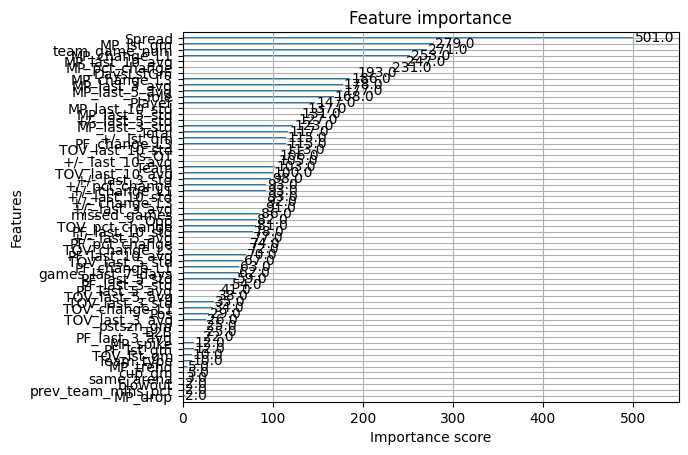

In [30]:
df_mins = df.copy()
df_mins = setup_df_mins(con, df_mins)
display(df_mins)

n = len(df_mins)
train_end = int(0.8 * n)
val_end   = int(0.9 * n)
mins_train_df = df_mins.iloc[:train_end]
mins_val_df   = df_mins.iloc[train_end:val_end]
mins_test_df  = df_mins.iloc[val_end:]
mins_DFS = (mins_train_df, mins_val_df, mins_test_df)

# mins_model = create_baseline_model(df_mins, "MP", mins_DFS)
mins_model, mins_preds, y_test_mins, analyze_df_mins = hyperparam_tuning(mins_DFS, "MP", n_iter=1)
feature_importance(mins_model)

In [10]:
rmse = np.sqrt(mean_squared_error(y_test_mins, mins_preds)) # splits[5] = y_test
mae = mean_absolute_error(y_test_mins, mins_preds)
print('RMSE:', rmse)

df_yesterday = pd.read_csv(f'../tables/2025/gmday_preds_{tgt_stat}.csv')
df_yesterday['Date'] = pd.to_datetime(df_yesterday.Date)
df_yesterday = df_yesterday[(df_yesterday.Date == (datetime.strptime(now, "%Y-%m-%d") - timedelta(days=1)).strftime("%Y-%m-%d"))]\
                .rename(columns={"MP": "MP_proj"})

df_gms = pd.read_csv(f"../tables/2025/season_gamelogs.csv")
df_gms['Date'] = pd.to_datetime(df_gms.Date)

df_yesterday = df_yesterday.merge(df_gms[['Date', 'Team', 'Player', 'MP']], on=['Date', 'Team', 'Player'])
df_yesterday = df_yesterday[['Date', 'Team', 'Player', 'Pos', 'Opp', 'MP_proj', 'MP', 'MP_last_5_avg']][df_yesterday.MP > 0]

df_yesterday['Diff'] = abs(df_yesterday['MP_proj'] - df_yesterday['MP'])
df_yesterday['InRMSE_Range'] = np.where(df_yesterday['Diff'] <= rmse, 1, 0)

print("\nYesterday's Results:")
print("Total Accuracy (InRMSE_Range):", ((df_yesterday.InRMSE_Range == 1).sum() / df_yesterday.shape[0]))
print((df_yesterday.InRMSE_Range == 1).sum(), '/', df_yesterday.shape[0])

df_yesterday = df_yesterday.drop(['Diff'], axis=1)

if df_yesterday.shape[0] >= 50:
    for tm in df_yesterday.Team.unique():
        display(df_yesterday[df_yesterday.Team == tm])
else:
    display(df_yesterday)

RMSE: 5.720458827377309

Yesterday's Results:
Total Accuracy (InRMSE_Range): 0.6451612903225806
40 / 62


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
0,2026-01-01,DET,Cade Cunningham,PG,MIA,34.219864,39.58,33.663177,1
6,2026-01-01,DET,Jalen Duren,C,MIA,28.413925,18.35,28.029231,0
11,2026-01-01,DET,Marcus Sasser,PG,MIA,4.085835,23.90,5.157729,0
24,2026-01-01,DET,Jaden Ivey,SG,MIA,17.785282,21.40,16.627817,1
26,2026-01-01,DET,Ausar Thompson,SF,MIA,23.843704,30.27,25.067089,0
27,2026-01-01,DET,Isaiah Stewart,C,MIA,21.565430,30.18,22.238527,0
39,2026-01-01,DET,Duncan Robinson,SF,MIA,27.297050,20.32,26.812035,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
1,2026-01-01,LAC,Kawhi Leonard,SF,UTA,35.576481,39.22,32.029076,1
4,2026-01-01,LAC,James Harden,PG,UTA,35.150322,28.88,32.507510,0
18,2026-01-01,LAC,John Collins,PF,UTA,24.889006,19.90,25.725887,1
40,2026-01-01,LAC,Kris Dunn,PG,UTA,26.765999,24.35,27.673838,1
48,2026-01-01,LAC,Nicolas Batum,PF,UTA,22.860626,27.72,20.803753,1
52,2026-01-01,LAC,Derrick Jones Jr.,SF,UTA,19.762583,24.13,9.200103,1
60,2026-01-01,LAC,Brook Lopez,C,UTA,22.432751,19.88,14.858392,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
2,2026-01-01,DAL,Anthony Davis,PF,PHI,29.041307,36.92,32.165636,0
43,2026-01-01,DAL,Cooper Flagg,PG,PHI,35.674217,36.67,35.825284,1
50,2026-01-01,DAL,Klay Thompson,SF,PHI,20.527676,13.08,21.121060,0
56,2026-01-01,DAL,Naji Marshall,SF,PHI,31.832495,22.42,32.540446,0
58,2026-01-01,DAL,P.J. Washington,PF,PHI,32.009285,34.47,32.396485,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
3,2026-01-01,BOS,Jaylen Brown,SF,SAC,34.700569,34.77,35.294588,1
21,2026-01-01,BOS,Derrick White,SG,SAC,34.654816,34.53,33.603950,1
25,2026-01-01,BOS,Luka Garza,C,SAC,14.472895,25.40,9.054584,0
29,2026-01-01,BOS,Neemias Queta,C,SAC,27.464378,22.60,26.873266,1
31,2026-01-01,BOS,Payton Pritchard,PG,SAC,33.787849,30.68,32.462648,1
33,2026-01-01,BOS,Hugo Gonzalez,SF,SAC,14.368828,18.50,11.751375,1
38,2026-01-01,BOS,Jordan Walsh,PF,SAC,16.962778,5.10,21.295493,0
46,2026-01-01,BOS,Anfernee Simons,SG,SAC,27.054113,30.32,26.012280,1
49,2026-01-01,BOS,Sam Hauser,PF,SAC,18.573156,29.45,19.348744,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
5,2026-01-01,UTA,Kyle Filipowski,C,LAC,18.796051,28.42,19.816994,0
8,2026-01-01,UTA,Taylor Hendricks,PF,LAC,10.265573,16.58,11.385328,0
9,2026-01-01,UTA,Svi Mykhailiuk,SF,LAC,10.244181,23.62,17.761933,0
13,2026-01-01,UTA,Isaiah Collier,PG,LAC,24.345707,36.95,21.206362,0
22,2026-01-01,UTA,Brice Sensabaugh,SF,LAC,26.623276,31.62,15.340862,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
7,2026-01-01,PHI,Tyrese Maxey,PG,DAL,37.826263,42.43,37.480161,1
15,2026-01-01,PHI,Joel Embiid,C,DAL,33.417721,35.35,30.210608,1
45,2026-01-01,PHI,VJ Edgecombe,SG,DAL,35.016960,39.55,34.879176,1
54,2026-01-01,PHI,Paul George,PF,DAL,33.573547,33.10,31.202763,1
59,2026-01-01,PHI,Quentin Grimes,SG,DAL,32.210052,38.48,34.152004,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
10,2026-01-01,HOU,Kevin Durant,SF,BRK,35.295269,36.55,34.661830,1
12,2026-01-01,HOU,Alperen Sengun,C,BRK,33.308540,33.67,36.270863,1
28,2026-01-01,HOU,Tari Eason,PF,BRK,23.111835,22.03,17.450593,1
30,2026-01-01,HOU,Amen Thompson,SF,BRK,36.035515,32.45,34.468141,1
32,2026-01-01,HOU,Reed Sheppard,PG,BRK,26.038395,31.35,27.323019,1
34,2026-01-01,HOU,Jabari Smith Jr.,PF,BRK,34.613556,32.40,34.539975,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
14,2026-01-01,MIA,Nikola Jovic,PF,DET,8.380295,23.90,11.563591,0
16,2026-01-01,MIA,Bam Adebayo,C,DET,28.467058,32.88,31.792611,1
17,2026-01-01,MIA,Norman Powell,SG,DET,31.893318,34.68,30.283946,1
35,2026-01-01,MIA,Davion Mitchell,PG,DET,29.890682,33.30,24.800472,1
42,2026-01-01,MIA,Andrew Wiggins,SF,DET,31.778696,31.52,29.665039,1
44,2026-01-01,MIA,Jaime Jaquez Jr.,SF,DET,30.710266,29.75,28.242663,1
57,2026-01-01,MIA,Dru Smith,SG,DET,18.870333,14.70,15.982795,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
19,2026-01-01,BRK,Danny Wolf,PF,HOU,20.737682,29.28,18.895098,0
41,2026-01-01,BRK,Noah Clowney,PF,HOU,28.183922,25.80,28.696814,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
20,2026-01-01,SAC,Russell Westbrook,PG,BOS,28.384441,26.55,30.444868,1
23,2026-01-01,SAC,Nique Clifford,SG,BOS,25.733894,16.48,17.746262,0
36,2026-01-01,SAC,DeMar DeRozan,PF,BOS,33.409107,34.53,32.634791,1
37,2026-01-01,SAC,Malik Monk,SG,BOS,20.982601,6.37,24.768333,0
47,2026-01-01,SAC,Maxime Raynaud,C,BOS,30.227562,34.72,26.273922,1
51,2026-01-01,SAC,Keegan Murray,PF,BOS,35.463440,37.80,36.435524,1
53,2026-01-01,SAC,Precious Achiuwa,C,BOS,17.028782,21.67,16.442179,1
55,2026-01-01,SAC,Dennis Schroder,PG,BOS,27.830364,27.90,27.133882,1
61,2026-01-01,SAC,Keon Ellis,SG,BOS,14.349081,26.97,14.077858,0


# Main Model

In [11]:
def setup_df_main(df):
    
    # Stat dependent features 
    if tgt_stat == 'PTS':
        tgt_stat_cols = ['PTS']
        df = df[['Season', 'Date', 'Team', 'Opp', 'Player', 'Pos', 'MP', 
         'PTS', 'TPM', 
         'FG', 'FGA', 'TPA', 'FT', 'FTA', f'Def_{tgt_stat}', f'Def_L5_{tgt_stat}',
         'Spread', 'Total', 'is_OT']]
        
        # Efficiency metrics
        df['three_rate_raw'] =  np.where(df.FGA > 0, df['TPA'] / df['FGA'], 0)
        df['ft_rate_raw']    =  np.where(df.FGA > 0, df['FTA'] / df['FGA'], 0)
        df['eFG_raw'] = (df['FG'] + 0.5 * df['TPM']) / df['FGA']
        df['TS_raw'] = df['PTS'] / (2 * (df['FGA'] + 0.44 * df['FTA']))    
        df['usage_proxy_raw'] =  np.where(df.MP > 0, (df['FGA'] + 0.44 * df['FTA']) / df['MP'], 0)
        
        for w in [3, 5, 10]:
            for metric in ['three_rate', 'ft_rate', 'eFG', 'TS', 'usage_proxy']:
                col = f"{metric}_L{w}"
                df[col] = (
                    df.groupby(['Player','Season'])[f'{metric}_raw']
                      .rolling(w, min_periods=1)
                      .mean()
                      .shift(1)
                      .reset_index(level=[0,1], drop=True)
                )
        for metric in ['three_rate', 'ft_rate', 'eFG', 'TS', 'usage_proxy']:
            col = f'{metric}_weighted'
            df[col] = (
                0.6 * df[f'{metric}_L3'] +
                0.3 * df[f'{metric}_L5'] +
                0.1 * df[f'{metric}_L10']
            )
            df = df.drop(f'{metric}_raw', axis=1)
        
    elif tgt_stat == 'PRA':
        tgt_stat_cols = ['PTS', 'REB', 'AST', 'TOV']
        df = df[['Season', 'Date', 'Team', 'Opp', 'Player', 'Pos', 'MP', 
         'PTS', 'AST', 'REB', 'PR', 'PA', 'RA', 'PRA', 'TPM', 'STL', 'BLK', 'STL_BLK', 'TOV',
         'FG', 'FGA', 'TPA', 'FT', 'FTA', f'Def_{tgt_stat}', f'Def_L5_{tgt_stat}',
         'Spread', 'Total', 'is_OT']]
        
        df['usage_proxy_raw'] =  np.where(df.MP > 0, (df['FGA'] + 0.44 * df['FTA']) / df['MP'], 0)
        for w in [3, 5, 10]:
            df[f"usage_proxy_L{w}"] = (
                df.groupby(['Player','Season'])[f'usage_proxy_raw']
                  .rolling(w, min_periods=1)
                  .mean()
                  .shift(1)
                  .reset_index(level=[0,1], drop=True)
            )
        df['usage_proxy_weighted'] = (
            0.6 * df[f'usage_proxy_L3'] +
            0.3 * df[f'usage_proxy_L5'] +
            0.1 * df[f'usage_proxy_L10']
        )
        df = df.drop('usage_proxy_raw', axis=1)
        
        
    else:
        tgt_stat_cols = []
        df = df[['Season', 'Date', 'Team', 'Opp', 'Player', 'Pos', 'MP', 
         'PTS', 'AST', 'REB', 'PR', 'PA', 'RA', 'PRA', 'TPM', 'STL', 'BLK', 'STL_BLK',
         'FG', 'FGA', 'TPA', 'FT', 'FTA', f'Def_{tgt_stat}', f'Def_L5_{tgt_stat}',
         'Spread', 'Total', 'is_OT']]

    
    # Create rolling + lag features    
    for col in ['MP', 'FGA', 'TPA', 'FTA', tgt_stat] + tgt_stat_cols:
        df[f'{col}_lst_gm'] = (
            df
            .groupby(['Player', 'Season'])[col]
            .shift(1)
        )
        for N in [3, 5, 10]:
            df[f'{col}_last_{N}_avg'] = (
                df.groupby(['Player', 'Season'])[col]
                  .rolling(window=N, min_periods=1)
                  .mean()
                  .shift(1)
                  .reset_index(level=[0, 1], drop=True)
            )
            df[f"{col}_last_{N}_std"] = (
                df.groupby(['Player', 'Season'])[col]
                  .shift(1)
                  .rolling(window=N, min_periods=1)
                  .std()
            )

    # Role identifiers features
    df['reserve_td'] = (df.MP < 8).astype(int)
    df['bench_td']   = ((df.MP >= 8) & (df.MP <= 25)).astype(int)
    df['starter_td'] = (df.MP > 25).astype(int)
    role_counts = df.groupby(['Season', 'Player'])[['reserve_td', 'bench_td', 'starter_td']].sum()
    role_counts['most_common_role'] = role_counts[['reserve_td', 'bench_td', 'starter_td']].idxmax(axis=1)
    role_counts['reserve'] = (role_counts['most_common_role'] == 'reserve_td').astype(int)
    role_counts['bench']   = (role_counts['most_common_role'] == 'bench_td').astype(int)
    role_counts['starter'] = (role_counts['most_common_role'] == 'starter_td').astype(int)
    df = df.merge(role_counts[['reserve', 'bench', 'starter']], on=['Season', 'Player'], how='left')
    df['role'] = 0
    df['role'] = np.where(df.starter == 1, 1, df.role)
    df['role'] = np.where(df.bench == 1, 2, df.role)
    df['role'] = np.where(df.reserve == 1, 3, df.role)
    
    for col in categories + ['Season', 'FG', 'FGA', 'FT', 'FTA', 'TPM', 'TPA', 
                             'reserve_td', 'reserve', 'bench_td', 'bench', 'starter_td', 'starter'] + tgt_stat_cols:
        if col == tgt_stat:
            continue
        if col in df.columns:
            df = df.drop(col, axis=1)
        
    return df

,Date,Team,Opp,Player,Pos,MP,PRA,Def_PRA,Def_L5_PRA,Spread,Total,is_OT,usage_proxy_L3,usage_proxy_L5,usage_proxy_L10,usage_proxy_weighted,MP_lst_gm,MP_last_3_avg,MP_last_3_std,MP_last_5_avg,MP_last_5_std,MP_last_10_avg,MP_last_10_std,FGA_lst_gm,FGA_last_3_avg,FGA_last_3_std,FGA_last_5_avg,FGA_last_5_std,FGA_last_10_avg,FGA_last_10_std,TPA_lst_gm,TPA_last_3_avg,TPA_last_3_std,TPA_last_5_avg,TPA_last_5_std,TPA_last_10_avg,TPA_last_10_std,FTA_lst_gm,FTA_last_3_avg,FTA_last_3_std,FTA_last_5_avg,FTA_last_5_std,FTA_last_10_avg,FTA_last_10_std,PRA_lst_gm,PRA_last_3_avg,PRA_last_3_std,PRA_last_5_avg,PRA_last_5_std,PRA_last_10_avg,PRA_last_10_std,PTS_lst_gm,PTS_last_3_avg,PTS_last_3_std,PTS_last_5_avg,PTS_last_5_std,PTS_last_10_avg,PTS_last_10_std,REB_lst_gm,REB_last_3_avg,REB_last_3_std,REB_last_5_avg,REB_last_5_std,REB_last_10_avg,REB_last_10_std,AST_lst_gm,AST_last_3_avg,AST_last_3_std,AST_last_5_avg,AST_last_5_std,AST_last_10_avg,AST_last_10_std,TOV_lst_gm,TOV_last_3_avg,TOV_last_3_std,TOV_last_5_avg,TOV_last_5_std,TOV_last_10_avg,TOV_last_10_std,role
0,2022-10-18,1,22,15,0,23.10,12.0,16.000000,16.0,9.0,243.0,0,0.411417,0.474603,0.401318,0.429363,NaN,22.200000,NaN,22.340,NaN,23.495000,NaN,NaN,7.000000,NaN,8.8,NaN,8.000000,NaN,NaN,2.666667,NaN,2.6,NaN,2.500000,NaN,NaN,4.666667,NaN,4.0,NaN,3.100000,NaN,NaN,19.333333,NaN,20.6,NaN,18.900000,NaN,NaN,13.333333,NaN,14.0,NaN,12.000000,NaN,NaN,2.666667,NaN,3.8,NaN,3.600000,NaN,NaN,3.333333,NaN,2.8,NaN,3.300000,NaN,NaN,0.666667,NaN,1.0,NaN,1.2,NaN,1
1,2022-10-18,1,22,61,0,8.28,7.0,16.000000,16.0,9.0,243.0,0,0.302402,0.286831,0.167386,0.284229,NaN,5.410000,NaN,3.964,NaN,6.374000,NaN,NaN,1.333333,NaN,0.8,NaN,0.600000,NaN,NaN,0.000000,NaN,0.0,NaN,0.000000,NaN,NaN,0.000000,NaN,0.4,NaN,0.200000,NaN,NaN,2.666667,NaN,2.0,NaN,1.900000,NaN,NaN,2.000000,NaN,1.4,NaN,0.900000,NaN,NaN,0.333333,NaN,0.4,NaN,0.700000,NaN,NaN,0.333333,NaN,0.2,NaN,0.300000,NaN,NaN,0.333333,NaN,0.2,NaN,0.3,NaN,2
2,2022-10-18,1,22,189,4,24.03,9.0,9.000000,9.0,9.0,243.0,0,0.321647,0.371026,0.392727,0.343569,NaN,11.733333,NaN,13.474,NaN,12.434000,NaN,NaN,3.666667,NaN,4.8,NaN,4.700000,NaN,NaN,0.333333,NaN,0.8,NaN,1.100000,NaN,NaN,0.000000,NaN,0.6,NaN,0.600000,NaN,NaN,7.333333,NaN,11.2,NaN,10.200000,NaN,NaN,4.000000,NaN,6.0,NaN,5.800000,NaN,NaN,1.000000,NaN,2.2,NaN,1.600000,NaN,NaN,2.333333,NaN,3.0,NaN,2.800000,NaN,NaN,2.000000,NaN,1.2,NaN,1.0,NaN,1
3,2022-10-18,1,22,257,1,23.95,17.0,17.000000,17.0,9.0,243.0,0,0.354274,0.364454,0.379668,0.359868,NaN,14.046667,NaN,14.498,NaN,14.405000,NaN,NaN,4.333333,NaN,4.6,NaN,5.000000,NaN,NaN,2.666667,NaN,2.4,NaN,2.700000,NaN,NaN,2.000000,NaN,1.8,NaN,1.100000,NaN,NaN,7.666667,NaN,7.8,NaN,7.100000,NaN,NaN,6.333333,NaN,5.2,NaN,5.000000,NaN,NaN,1.000000,NaN,1.6,NaN,1.400000,NaN,NaN,0.333333,NaN,1.0,NaN,0.700000,NaN,NaN,0.333333,NaN,0.4,NaN,0.6,NaN,1
4,2022-10-18,1,22,357,3,38.57,40.0,91.000000,91.0,9.0,243.0,0,0.322357,0.322357,0.322357,0.322357,NaN,15.055000,NaN,15.055,NaN,15.055000,NaN,NaN,3.500000,NaN,3.5,NaN,3.500000,NaN,NaN,1.000000,NaN,1.0,NaN,1.000000,NaN,NaN,1.000000,NaN,1.0,NaN,1.000000,NaN,NaN,10.000000,NaN,10.0,NaN,10.000000,NaN,NaN,6.500000,NaN,6.5,NaN,6.500000,NaN,NaN,3.000000,NaN,3.0,NaN,3.000000,NaN,NaN,0.500000,NaN,0.5,NaN,0.500000,NaN,NaN,1.500000,NaN,1.5,NaN,1.5,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84142,2026-01-01,28,12,487,3,31.67,31.0,43.259259,52.2,-17.0,219.0,0,0.361934,0.333463,0.369850,0.354184,15.45,14.800000,5.724564,18.514,10.360950,17.941111,9.405284,4.0,4.333333,1.000000,5.4,3.114482,5.444444,3.326660,0.0,0.000000,1.000000,0.2,2.408319,0.111111,2.110819,0.0,2.000000,1.154701,1.2,1.095445,1.666667,0.948683,3.0,9.000000,10.692677,12.2,8.820431,12.333333,8.633912,0.0,5.000000,3.605551


Trial 1/1: {'n_estimators': 1097, 'learning_rate': np.float64(0.013460118975745552), 'max_depth': 5, 'min_child_weight': 1, 'subsample': np.float64(0.7600424732121637), 'colsample_bytree': np.float64(0.9964891922731243), 'gamma': np.float64(1.9202154125012725), 'reg_lambda': np.float64(3.15446496685123), 'reg_alpha': np.float64(1.03399222476961)}
Validation MAE: 4.1673

Best validation MAE: 4.167260308254069
Best parameters: {'learning_rate': np.float64(0.013460118975745552), 'max_depth': 5, 'min_child_weight': 1, 'subsample': np.float64(0.7600424732121637), 'colsample_bytree': np.float64(0.9964891922731243), 'gamma': np.float64(1.9202154125012725), 'reg_lambda': np.float64(3.15446496685123), 'reg_alpha': np.float64(1.03399222476961), 'objective': 'reg:squarederror', 'tree_method': 'hist', 'device': 'cuda', 'seed': 42}

Test Metrics:
RMSE: 5.700752811307503
MAE: 4.287197228704968
R²: 0.7922558438009665


,feature,importance,pct
0,PRA_last_10_avg,41567.875000,0.302225
1,MP,40185.199219,0.594397
2,PRA_last_5_avg,4015.312500,0.623591
3,usage_proxy_L10,3724.364502,0.650669
4,usage_proxy_L5,3470.433594,0.675901
...,...,...,...
73,TPA_last_3_std,309.262726,0.991967
74,FTA_last_3_std,305.035858,0.994185
75,TPA_last_10_std,289.585114,0.996290
76,Opp,264.544434,0.998213


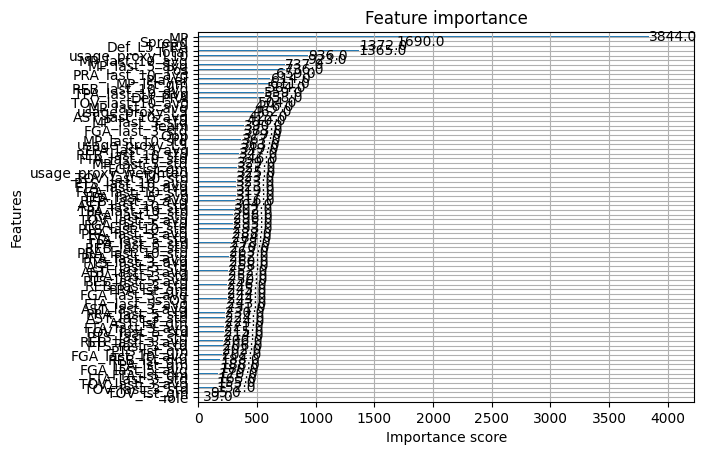

In [47]:
df_main = df.copy()
df_main = setup_df_main(df_main)
display(df_main)

n = len(df_main)
train_end = int(0.65 * n)
val_end   = int(0.85 * n)
main_train_df = df_main.iloc[:train_end]
main_val_df   = df_main.iloc[train_end:val_end]
main_test_df  = df_main.iloc[val_end:]
main_DFS = (main_train_df, main_val_df, main_test_df)

# stat_model = create_baseline_model(df_main, tgt_stat, main_DFS)
stat_model, stat_preds, y_test_stat, analyze_df_stat = hyperparam_tuning(main_DFS, tgt_stat, n_iter=1)
feature_importance(stat_model)

In [48]:
# analyze_df_stat = main_test_df.drop([tgt_stat, f'{tgt_stat}_preds'], axis=1)\
#                 .merge(analyze_df_stat[['Date', 'Team', 'Player', tgt_stat, f'{tgt_stat}_preds']], on=['Date', 'Team', 'Player'])
# analyze_df_stat['Diff'] = analyze_df_stat[tgt_stat] - analyze_df_stat[f'{tgt_stat}_preds']
# analyze_df_stat[analyze_df_stat.MP > 38].sort_values('Diff', ascending=True).head(15)

In [49]:
rmse = np.sqrt(mean_squared_error(y_test_stat, stat_preds)) # splits[5] = y_test
mae = mean_absolute_error(y_test_stat, stat_preds)
print('RMSE:', rmse)

df_yesterday = pd.read_csv(f'../tables/2025/gmday_preds_{tgt_stat}.csv')
df_yesterday['Date'] = pd.to_datetime(df_yesterday.Date)
df_yesterday = df_yesterday[(df_yesterday.Date == (datetime.strptime(now, "%Y-%m-%d") - timedelta(days=1)).strftime("%Y-%m-%d"))]\
                .rename(columns={"MP": "MP_proj"})

df_gms = pd.read_csv(f"../tables/2025/season_gamelogs.csv")
df_gms['Date'] = pd.to_datetime(df_gms.Date)
df_gms = df_gms.rename(columns={"TRB": "REB", "3PM": "TPM", "3PA": "TPA"})
df_gms['STL_BLK'] = df_gms.STL + df_gms.BLK
df_gms['PR'] = df_gms.PTS + df_gms.REB 
df_gms['PA'] = df_gms.PTS + df_gms.AST
df_gms['RA'] = df_gms.REB + df_gms.AST
df_gms['PRA'] = df_gms.PTS + df_gms.REB + df_gms.AST

df_yesterday = df_yesterday.merge(df_gms[['Date', 'Team', 'Player', tgt_stat, 'MP']], on=['Date', 'Team', 'Player'])
df_yesterday = df_yesterday[['Date', 'Team', 'Player', 'Pos', 'Opp', 'MP_proj', 'MP', f'{tgt_stat}_line', f'{tgt_stat}_proj', tgt_stat]][df_yesterday.MP > 0]

df_yesterday['Diff'] = df_yesterday[f'{tgt_stat}_proj'] - df_yesterday[f'{tgt_stat}_line']
df_yesterday['Diff2'] = abs(df_yesterday[f'{tgt_stat}_proj'] - df_yesterday[tgt_stat])
df_yesterday['Act_Res'] = np.where(df_yesterday[tgt_stat] > df_yesterday[f'{tgt_stat}_line'], 'O', 'U')
df_yesterday['Pred_Res'] = np.where(df_yesterday[f'{tgt_stat}_proj'] > df_yesterday[f'{tgt_stat}_line'], 'O', 'U')
df_yesterday['ParlayHit'] = np.where(df_yesterday['Act_Res'] == df_yesterday['Pred_Res'], 1, 0)
df_yesterday['InRMSE_Range'] = np.where(df_yesterday['Diff2'] <= rmse, 1, 0)

print("Total Accuracy (ParlayHit):", ((df_yesterday.ParlayHit == 1).sum() / df_yesterday.shape[0]))
print((df_yesterday.ParlayHit == 1).sum(), "/", df_yesterday.shape[0])

print("\nTotal Accuracy (InRMSE_Range):", ((df_yesterday.InRMSE_Range == 1).sum() / df_yesterday.shape[0]))
print((df_yesterday.InRMSE_Range == 1).sum(), "/", df_yesterday.shape[0])

df_yesterday = df_yesterday.drop(['Diff', 'Act_Res', 'Pred_Res'], axis=1).sort_values(f'{tgt_stat}_line', ascending=False)

if df_yesterday.shape[0] >= 50:
    for tm in df_yesterday.Team.unique():
        display(df_yesterday[df_yesterday.Team == tm])
else:
    display(df_yesterday)

RMSE: 5.700752811307503
Total Accuracy (ParlayHit): 0.6129032258064516
38 / 62

Total Accuracy (InRMSE_Range): 0.532258064516129
33 / 62


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
0,2026-01-01,DET,Cade Cunningham,PG,MIA,34.219864,39.58,43.5,25.632751,50,24.367249,0,0
6,2026-01-01,DET,Jalen Duren,C,MIA,28.413925,18.35,32.5,19.398735,17,2.398735,1,1
26,2026-01-01,DET,Ausar Thompson,SF,MIA,23.843704,30.27,19.5,14.895693,16,1.104307,1,1
27,2026-01-01,DET,Isaiah Stewart,C,MIA,21.565430,30.18,18.5,13.974857,12,1.974857,1,1
39,2026-01-01,DET,Duncan Robinson,SF,MIA,27.297050,20.32,15.5,12.878543,13,0.121457,1,1
24,2026-01-01,DET,Jaden Ivey,SG,MIA,17.785282,21.40,15.5,10.657265,6,4.657265,1,1
11,2026-01-01,DET,Marcus Sasser,PG,MIA,4.085835,23.90,12.5,2.898100,24,21.101900,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
1,2026-01-01,LAC,Kawhi Leonard,SF,UTA,35.576481,39.22,41.5,23.677233,55,31.322767,0,0
4,2026-01-01,LAC,James Harden,PG,UTA,35.150322,28.88,40.5,24.563087,30,5.436913,1,1
18,2026-01-01,LAC,John Collins,PF,UTA,24.889006,19.90,21.5,14.152607,19,4.847393,1,1
60,2026-01-01,LAC,Brook Lopez,C,UTA,22.432751,19.88,19.5,19.130199,6,13.130199,1,0
40,2026-01-01,LAC,Kris Dunn,PG,UTA,26.765999,24.35,15.5,13.089392,6,7.089392,1,0
52,2026-01-01,LAC,Derrick Jones Jr.,SF,UTA,19.762583,24.13,12.5,13.238705,17,3.761295,1,1
48,2026-01-01,LAC,Nicolas Batum,PF,UTA,22.860626,27.72,9.5,11.107941,17,5.892059,1,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
3,2026-01-01,BOS,Jaylen Brown,SF,SAC,34.700569,34.77,41.5,25.420444,43,17.579556,0,0
21,2026-01-01,BOS,Derrick White,SG,SAC,34.654816,34.53,28.5,22.979179,28,5.020821,1,1
31,2026-01-01,BOS,Payton Pritchard,PG,SAC,33.787849,30.68,27.5,23.498312,25,1.501688,1,1
29,2026-01-01,BOS,Neemias Queta,C,SAC,27.464378,22.60,21.5,17.226349,18,0.773651,1,1
46,2026-01-01,BOS,Anfernee Simons,SG,SAC,27.054113,30.32,17.5,15.802164,20,4.197836,0,1
25,2026-01-01,BOS,Luka Garza,C,SAC,14.472895,25.40,14.5,9.895070,16,6.104930,0,0
33,2026-01-01,BOS,Hugo Gonzalez,SF,SAC,14.368828,18.50,11.5,7.998579,10,2.001421,1,1
49,2026-01-01,BOS,Sam Hauser,PF,SAC,18.573156,29.45,11.5,10.232536,21,10.767464,0,0
38,2026-01-01,BOS,Jordan Walsh,PF,SAC,16.962778,5.10,10.5,7.847263,1,6.847263,1,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
7,2026-01-01,PHI,Tyrese Maxey,PG,DAL,37.826263,42.43,38.5,27.204241,52,24.795759,0,0
15,2026-01-01,PHI,Joel Embiid,C,DAL,33.417721,35.35,37.5,29.217464,32,2.782536,1,1
54,2026-01-01,PHI,Paul George,PF,DAL,33.573547,33.10,25.5,24.952236,23,1.952236,1,1
45,2026-01-01,PHI,VJ Edgecombe,SG,DAL,35.016960,39.55,23.5,25.594717,30,4.405283,1,1
59,2026-01-01,PHI,Quentin Grimes,SG,DAL,32.210052,38.48,17.5,17.872929,28,10.127071,1,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
2,2026-01-01,DAL,Anthony Davis,PF,PHI,29.041307,36.92,37.5,20.517797,23,2.482203,1,1
43,2026-01-01,DAL,Cooper Flagg,PG,PHI,35.674217,36.67,30.5,28.347782,26,2.347782,1,1
58,2026-01-01,DAL,P.J. Washington,PF,PHI,32.009285,34.47,22.5,22.076384,17,5.076384,1,1
56,2026-01-01,DAL,Naji Marshall,SF,PHI,31.832495,22.42,19.5,19.997931,11,8.997931,0,0
50,2026-01-01,DAL,Klay Thompson,SF,PHI,20.527676,13.08,13.5,12.441420,12,0.441420,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
12,2026-01-01,HOU,Alperen Sengun,C,BRK,33.308540,33.67,35.5,26.143539,32,5.856461,1,0
10,2026-01-01,HOU,Kevin Durant,SF,BRK,35.295269,36.55,33.5,23.690022,38,14.309978,0,0
30,2026-01-01,HOU,Amen Thompson,SF,BRK,36.035515,32.45,28.5,24.300957,30,5.699043,0,1
34,2026-01-01,HOU,Jabari Smith Jr.,PF,BRK,34.613556,32.40,23.5,20.015678,21,0.984322,1,1
28,2026-01-01,HOU,Tari Eason,PF,BRK,23.111835,22.03,20.5,16.177990,24,7.822010,0,0
32,2026-01-01,HOU,Reed Sheppard,PG,BRK,26.038395,31.35,17.5,13.934270,17,3.065730,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
17,2026-01-01,MIA,Norman Powell,SG,DET,31.893318,34.68,29.5,21.811321,40,18.188679,0,0
16,2026-01-01,MIA,Bam Adebayo,C,DET,28.467058,32.88,28.5,20.623589,29,8.376411,0,0
44,2026-01-01,MIA,Jaime Jaquez Jr.,SF,DET,30.710266,29.75,24.5,22.394541,27,4.605459,0,1
42,2026-01-01,MIA,Andrew Wiggins,SF,DET,31.778696,31.52,22.5,20.200756,26,5.799244,0,0
35,2026-01-01,MIA,Davion Mitchell,PG,DET,29.890682,33.30,17.5,20.403111,20,0.403111,1,1
14,2026-01-01,MIA,Nikola Jovic,PF,DET,8.380295,23.90,15.5,6.855351,15,8.144649,1,0
57,2026-01-01,MIA,Dru Smith,SG,DET,18.870333,14.70,11.5,11.019665,10,1.019665,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
5,2026-01-01,UTA,Kyle Filipowski,C,LAC,18.796051,28.42,29.5,14.027472,11,3.027472,1,1
13,2026-01-01,UTA,Isaiah Collier,PG,LAC,24.345707,36.95,27.5,18.397453,32,13.602547,0,0
22,2026-01-01,UTA,Brice Sensabaugh,SF,LAC,26.623276,31.62,26.5,21.297758,26,4.702242,1,1
8,2026-01-01,UTA,Taylor Hendricks,PF,LAC,10.265573,16.58,17.5,6.619447,7,0.380553,1,1
9,2026-01-01,UTA,Svi Mykhailiuk,SF,LAC,10.244181,23.62,15.5,5.206024,8,2.793976,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
36,2026-01-01,SAC,DeMar DeRozan,PF,BOS,33.409107,34.53,26.5,23.610058,36,12.389942,0,0
20,2026-01-01,SAC,Russell Westbrook,PG,BOS,28.384441,26.55,26.5,20.681084,19,1.681084,1,1
47,2026-01-01,SAC,Maxime Raynaud,C,BOS,30.227562,34.72,23.5,25.159723,21,4.159723,0,1
51,2026-01-01,SAC,Keegan Murray,PF,BOS,35.463440,37.80,22.5,23.309916,17,6.309916,0,0
55,2026-01-01,SAC,Dennis Schroder,PG,BOS,27.830364,27.90,19.5,18.998781,28,9.001219,0,0
23,2026-01-01,SAC,Nique Clifford,SG,BOS,25.733894,16.48,13.5,18.619127,3,15.619127,0,0
53,2026-01-01,SAC,Precious Achiuwa,C,BOS,17.028782,21.67,12.5,11.807987,19,7.192013,0,0
37,2026-01-01,SAC,Malik Monk,SG,BOS,20.982601,6.37,10.5,13.323649,1,12.323649,0,0
61,2026-01-01,SAC,Keon Ellis,SG,BOS,14.349081,26.97,7.5,7.782199,18,10.217801,1,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PRA_line,PRA_proj,PRA,Diff2,ParlayHit,InRMSE_Range
41,2026-01-01,BRK,Noah Clowney,PF,HOU,28.183922,25.80,20.5,18.160801,12,6.160801,1,0
19,2026-01-01,BRK,Danny Wolf,PF,HOU,20.737682,29.28,20.5,13.578224,18,4.421776,1,1


### Today's predictions

In [50]:
df_lines = pd.read_csv(f"../tables/2025/parlay_lines.csv")
df_lines['Date'] = pd.to_datetime(df_lines.Date)
df_lines = df_lines[~(df_lines.Team.isnull())]

# Predict Mins
df_lines["Team"] = team_encoder.transform(df_lines["Team"])
df_pred = df_pred.merge(df_lines[['Date', 'Team', 'Spread', 'Total']], on=['Date', 'Team'], how='left')
df_pred = df_pred[~df_pred[['Date', 'Team', 'Player']].duplicated(keep='last')]
df_pred['Spread_x'] = np.where(df_pred.Spread_x.isnull(), df_pred.Spread_y, df_pred.Spread_x)
df_pred['Total_x'] = np.where(df_pred.Total_x.isnull(), df_pred.Total_y, df_pred.Total_x)
df_pred = df_pred.rename(columns={"Spread_x": "Spread", "Total_x": "Total"}).drop(['Spread_y', 'Total_y'], axis=1)
df_pred_mins = setup_df_mins(con, df_pred)
df_pred_mins = df_pred_mins.drop(['Date', 'MP'], axis=1)
DM_mins = xgb.DMatrix(df_pred_mins)
df_pred['MP'] = mins_model.predict(DM_mins)

# Predict Stat
df_pred = setup_df_main(df_pred)
feature_cols = [col for col in df_pred.columns if col not in ['Date', tgt_stat]]
df_pred = df_pred[df_pred.Date == now][feature_cols]
DM_stats = xgb.DMatrix(df_pred)
df_pred[f"{tgt_stat}_proj"] = stat_model.predict(DM_stats)

df_pred['Team'] = team_encoder.inverse_transform(df_pred["Team"])
df_lines['Team'] = team_encoder.inverse_transform(df_lines["Team"])
df_pred['Opp'] = team_encoder.inverse_transform(df_pred["Opp"])
df_pred['Player'] = player_encoder.inverse_transform(df_pred["Player"])
df_pred['Pos'] = position_encoder.inverse_transform(df_pred["Pos"])

df_lines = df_lines[df_lines.Date == now][['Team', 'Player', f'{tgt_stat}_line']]
df_pred = df_pred.merge(df_lines, on=['Team', 'Player'])

tds_picks = df_pred[~(df_pred[f'{tgt_stat}_line'].isnull())]\
            [['Team', 'Player', 'Pos', 'Opp', 'MP', 'MP_last_5_avg', f'{tgt_stat}_line', f'{tgt_stat}_proj']]
tds_picks['Diff'] = abs((df_pred[f'{tgt_stat}_line'] - df_pred[f'{tgt_stat}_proj']))
tds_picks['Diff2'] = abs((df_pred['MP'] - df_pred['MP_last_5_avg']))
tds_picks = tds_picks.sort_values('Diff', ascending=False).drop(['Diff', 'Diff2'], axis=1)
if tds_picks.shape[0] >= 50:
    print(tds_picks.shape[0], 'rows')
    for tm in tds_picks.Team.unique():
        display(tds_picks[tds_picks.Team == tm])
else:
    display(tds_picks)
tds_picks.insert(0, 'Date', pd.to_datetime(now))
partition_save_df(tds_picks, f"../tables/2025/gmday_preds_{tgt_stat}.csv")

77 rows


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
84,MIL,Giannis Antetokounmpo,PF,CHO,28.231833,28.064298,44.5,30.137384
3,MIL,Kevin Porter Jr.,PG,CHO,37.146896,34.435967,31.5,36.623344
6,MIL,Ryan Rollins,PG,CHO,31.785912,28.383511,24.5,27.329342
113,MIL,Myles Turner,C,CHO,29.491381,27.909576,19.5,22.054808


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
115,ATL,Onyeka Okongwu,C,NYK,33.968113,33.626593,24.5,35.495926
39,ATL,Dyson Daniels,SG,NYK,34.769489,33.973720,23.5,30.322981
64,ATL,Jalen Johnson,SF,NYK,35.618279,35.465738,43.5,49.157951
28,ATL,Nickeil Alexander-Walker,SG,NYK,33.061451,31.945737,26.5,29.909739
110,ATL,Kristaps Porzingis,C,NYK,23.709652,24.363633,20.5,21.350876


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
29,CLE,Donovan Mitchell,SG,DEN,32.349075,32.130327,39.5,28.887110
88,CLE,Evan Mobley,PF,DEN,28.835808,30.993872,29.5,24.864868
17,CLE,Darius Garland,PG,DEN,30.924549,31.293095,28.5,26.069103


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
26,PHO,Devin Booker,SG,SAC,31.896500,31.927121,36.5,26.402592
62,PHO,Dillon Brooks,SF,SAC,30.814096,29.613207,25.5,24.549198
22,PHO,Collin Gillespie,PG,SAC,31.671883,31.553231,24.5,23.575514
72,PHO,Royce O'Neale,SF,SAC,29.623608,27.969655,16.5,15.989944


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
85,NOP,Zion Williamson,PF,POR,30.114925,27.683939,36.5,28.004704
18,NOP,Jose Alvarado,PG,POR,19.169916,22.765549,15.5,9.960478
4,NOP,Jordan Poole,PG,POR,26.376066,27.835435,25.5,21.706345
124,NOP,Yves Missi,C,POR,18.115793,13.463325,16.5,13.154822
12,NOP,Jeremiah Fears,PG,POR,27.135372,26.591922,22.5,20.994465


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
8,ORL,Anthony Black,PG,CHI,33.817368,34.305905,25.5,33.355148
108,ORL,Wendell Carter Jr.,C,CHI,31.963394,31.270381,22.5,24.745956
9,ORL,Jalen Suggs,PG,CHI,29.589277,28.497968,23.5,25.638494
83,ORL,Paolo Banchero,PF,CHI,35.440369,33.519336,37.5,39.180389
33,ORL,Desmond Bane,SG,CHI,35.088852,35.481325,32.5,31.714214


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
42,SAS,Dylan Harper,SG,IND,19.695082,21.166991,21.5,14.436685
10,SAS,De'Aaron Fox,PG,IND,33.063480,30.344022,34.5,29.803329
13,SAS,Stephon Castle,PG,IND,32.119240,29.995776,32.5,29.583691
98,SAS,Harrison Barnes,PF,IND,27.028538,26.204134,18.5,16.053444


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
0,OKC,Shai Gilgeous-Alexander,PG,GSW,32.227650,31.503814,41.5,35.227722
31,OKC,Jalen Williams,SG,GSW,29.521282,28.882285,28.5,25.103779
34,OKC,Ajay Mitchell,SG,GSW,24.530567,25.586377,17.5,15.921733
56,OKC,Cason Wallace,SG,GSW,26.515209,26.095848,12.5,13.282351


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
69,CHO,Brandon Miller,SF,MIL,34.928066,32.221545,27.5,33.683685
86,CHO,Miles Bridges,PF,MIL,29.307453,32.007631,26.5,20.493446
14,CHO,LaMelo Ball,PG,MIL,29.749714,27.787810,33.5,32.442360
71,CHO,Kon Knueppel,SF,MIL,31.646755,32.808304,25.5,25.311337


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
67,POR,Deni Avdija,SF,NOP,36.702362,35.584127,45.5,39.445831
102,POR,Toumani Camara,PF,NOP,33.484592,31.987865,24.5,22.362980
109,POR,Donovan Clingan,C,NOP,27.811285,28.348401,25.5,23.779461
27,POR,Shaedon Sharpe,SG,NOP,32.794605,31.532763,32.5,33.680180


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
61,DEN,Jalen Pickett,SG,CLE,17.024099,11.682429,16.5,11.087135
7,DEN,Jamal Murray,PG,CLE,35.429695,35.834991,39.5,42.098755


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
19,SAC,Dennis Schroder,PG,PHO,27.197021,26.360287,18.5,23.874636
92,SAC,DeMar DeRozan,PF,PHO,32.454983,31.748291,25.5,29.744564
16,SAC,Russell Westbrook,PG,PHO,29.594584,30.254799,25.5,28.481976


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
15,CHI,Tre Jones,PG,ORL,25.961311,25.278191,23.5,18.465168
100,CHI,Matas Buzelis,PF,ORL,26.401369,26.733076,22.5,17.977570
74,CHI,Kevin Huerter,SF,ORL,23.234598,21.444281,20.5,16.260460
40,CHI,Ayo Dosunmu,SG,ORL,26.252743,24.324567,21.5,17.416807
121,CHI,Jalen Smith,C,ORL,22.076958,17.153244,22.5,19.485090
114,CHI,Nikola Vucevic,C,ORL,30.150158,28.118909,30.5,28.034611
105,CHI,Patrick Williams,PF,ORL,16.407253,12.473626,12.5,10.511208
55,CHI,Isaac Okoro,SG,ORL,23.024878,20.703801,14.5,14.809620


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
112,MEM,Jaren Jackson Jr.,C,LAL,32.724255,31.099556,27.5,31.942833
87,MEM,Santi Aldama,PF,LAL,33.679359,31.455962,23.5,27.197206
47,MEM,Cam Spencer,SG,LAL,24.699717,27.796679,16.5,19.290266
5,MEM,Ja Morant,PG,LAL,30.609859,26.896921,33.5,34.027992
41,MEM,Cedric Coward,SG,LAL,29.705704,26.999552,23.5,23.925093


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
2,LAL,Luka Doncic,PG,MEM,35.489624,32.994233,52.5,48.813866
49,LAL,Marcus Smart,SG,MEM,28.052872,25.733805,15.5,19.111080
63,LAL,LeBron James,SF,MEM,33.395782,31.022984,35.5,36.517902


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
70,NYK,Mikal Bridges,SF,ATL,36.313873,36.001933,25.5,21.836433
24,NYK,Tyler Kolek,PG,ATL,17.651819,21.285594,12.5,14.575378
95,NYK,OG Anunoby,PF,ATL,36.382931,33.626781,26.5,27.282545
1,NYK,Jalen Brunson,PG,ATL,36.017071,36.741358,41.5,41.222198


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
11,IND,Andrew Nembhard,PG,SAS,32.270748,31.502829,26.5,30.019604
65,IND,Bennedict Mathurin,SF,SAS,33.795750,31.299982,26.5,23.355600
89,IND,Pascal Siakam,PF,SAS,33.434097,31.652703,33.5,30.478035
68,IND,Aaron Nesmith,SF,SAS,26.762920,23.846235,19.5,17.858292
122,IND,Jay Huff,C,SAS,17.131289,21.752044,13.5,12.295998
20,IND,T.J. McConnell,PG,SAS,17.122589,16.307553,15.5,15.247924


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
37,GSW,Brandin Podziemski,SG,OKC,26.520077,29.038036,21.5,19.013983


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
54,WAS,Bilal Coulibaly,SG,BRK,28.451031,26.689699,17.5,19.866285
32,WAS,CJ McCollum,SG,BRK,33.362247,32.049277,25.5,24.753088
76,WAS,Khris Middleton,SF,BRK,22.583683,21.838331,16.5,16.709623


../tables/2025/gmday_preds_PRA.csv saved!
